In [ ]:
import anndata
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

In [2]:
ad_file = '../../data/downloads/buen_ad_sc.h5ad'
ad = anndata.read_h5ad(ad_file)

batch_m = pd.get_dummies(ad.obs['batch'])
batch_m.to_csv('batch_m.csv')

### preprocess

In [ ]:
!python ../../bin/scbasset_preprocess.py --ad_file ../../data/downloads/buen_ad_sc.h5ad --input_fasta /home/yuanh/programs/genomes/hg19/hg19.fa

### train

In [ ]:
!python ../../bin/scbasset_bc_train.py --input_folder processed/ --out_path output_bc --batch_csv batch_m.csv --l2 1e-8 --epochs 2000

In [ ]:
### to get cell embedding, denoise, tf activity inference, run the same functions with option bc_model=True

### evaluating a trained model

In [15]:
from sklearn import metrics

bottleneck_size = 32
batch_m = pd.read_csv('batch_m.csv', index_col=0)
n_cells = ad.shape[0]
model = make_model_bc(bottleneck_size, n_cells, batch_m, show_summary=False)

# trained_model = 'processed/best_model.h5'
# download the trained model
if not os.path.exists('%s/buen_model_sc_bc.h5'%download_savepath):
    subprocess.run('wget -P %s https://storage.googleapis.com/scbasset_tutorial_data/buen_model_sc_bc.h5'%download_savepath, shell=True)
trained_model = '../../data/downloads/buen_model_sc_bc.h5'
model.load_weights(trained_model)
proj = get_cell_embedding(model, bc_model=True)

ad.obsm['projection'] = proj

### compute adjusted rand index

/home/yuanh/programs/anaconda3/envs/tf28/lib/python3.7/site-packages/scanpy/tools/_tsne.py:115: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  "In previous versions of scanpy, calling tsne with n_jobs > 1 would use "
/home/yuanh/programs/anaconda3/envs/tf28/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


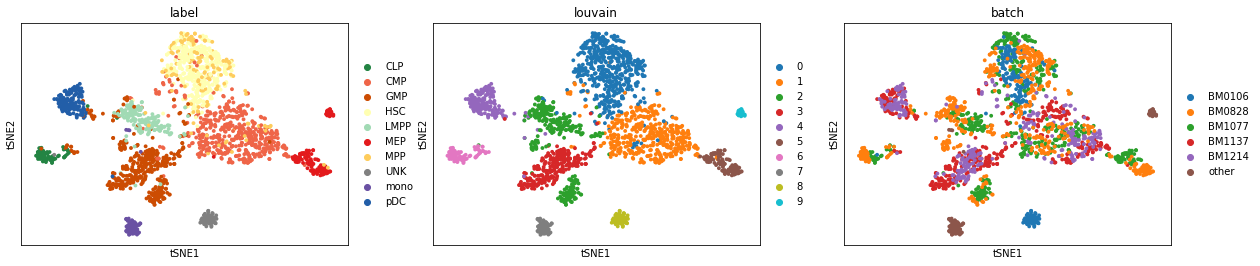

In [29]:
# from Chen et al. 2019:
# https://github.com/pinellolab/scATAC-benchmarking/blob/master/Synthetic_Data/BoneMarrow_clean/run_clustering_bonemarrow_clean.ipynb
def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    return (None, None)

sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection', n_jobs=8, random_state=700)
res, tmp = getNClusters(ad, n_cluster=10)

sc.tl.louvain(ad, resolution=res)
ari = metrics.adjusted_rand_score(ad.obs['label'], ad.obs['louvain'])

f = sc.pl.tsne(ad, color=['label','louvain', 'batch'], return_fig=True)


In [28]:
ari

0.6712183288695855